In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score


## Exploring The Server Machine Dataset

SMD (Server Machine Dataset) is a new 5-week-long dataset. We collected it from a large Internet company. This dataset contains 3 groups of entities. Each of them is named by *machine-group_index-index*.

SMD is made up by data from 28 different machines, and the 28 subsets should be trained and tested separately. For each of these subsets, we divide it into two parts of equal length for training and testing. We provide labels for whether a point is an anomaly and the dimensions contribute to every anomaly.

Thus SMD is made up by the following parts:

- train: The former half part of the dataset.
- test: The latter half part of the dataset.
- test_label: The label of the test set. It denotes whether a point is an anomaly.
- interpretation_label: The lists of dimensions contribute to each anomaly.

In [140]:
dataset = 'SMD'
data_path = "../ServerMachineDataset/processed"
x_dim = 38

file = 1, 2

In [141]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_train.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.16,0.058339,0.090032,0.114586,0.122642,0.899967,0.262767,0.0,0.000746,0.012437,...,0.0,0.0,0.045032,0.0,0.25,0.090278,0.0,0.0,0.0,0.0
1,0.11,0.048404,0.083601,0.111170,0.122642,0.859680,0.262093,0.0,0.000187,0.000315,...,0.0,0.0,0.028284,0.0,0.25,0.076389,0.0,0.0,0.0,0.0
2,0.11,0.044599,0.076923,0.107227,0.122642,0.860669,0.261962,0.0,0.000187,0.000005,...,0.0,0.0,0.034611,0.0,0.25,0.069444,0.0,0.0,0.0,0.0
3,0.12,0.053266,0.075686,0.105125,0.122642,0.781639,0.184000,0.0,0.000187,0.000438,...,0.0,0.0,0.071083,0.0,0.25,0.069444,0.0,0.0,0.0,0.0
4,0.11,0.044599,0.070492,0.101708,0.122642,0.702331,0.106054,0.0,0.000840,0.000000,...,0.0,0.0,0.025307,0.0,0.25,0.069444,0.0,0.0,0.0,0.0


<Figure size 432x288 with 0 Axes>

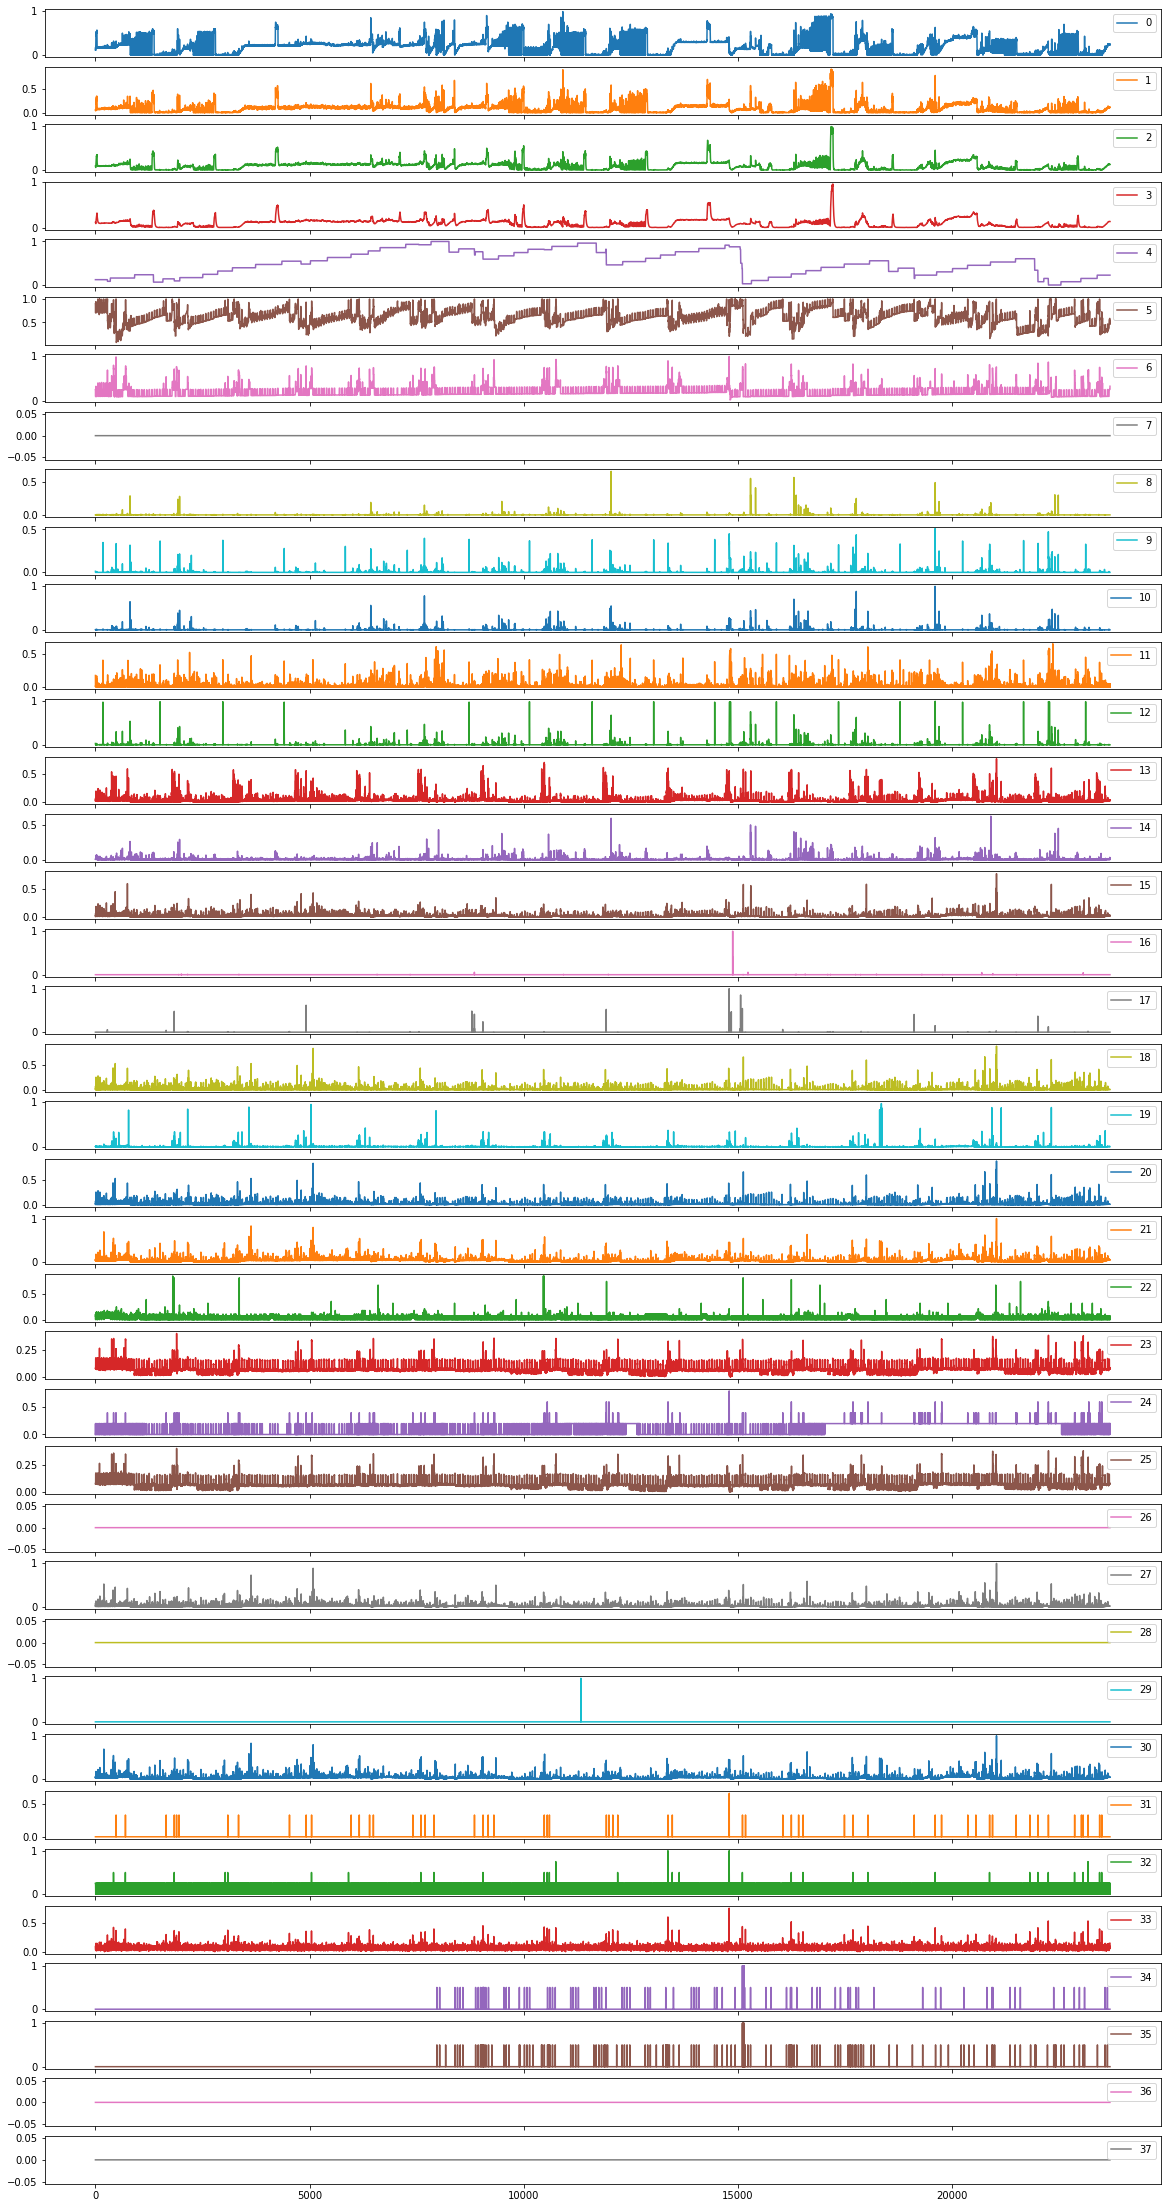

In [142]:
plt.tight_layout()
df.plot(subplots=True, figsize=(20,40))
plt.show();

In [143]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df_test = pd.DataFrame(data)

f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test_label.pkl', "rb")
test_labels = pickle.load(f)
f.close()
df_test['Anomaly'] = test_labels

<Figure size 432x288 with 0 Axes>

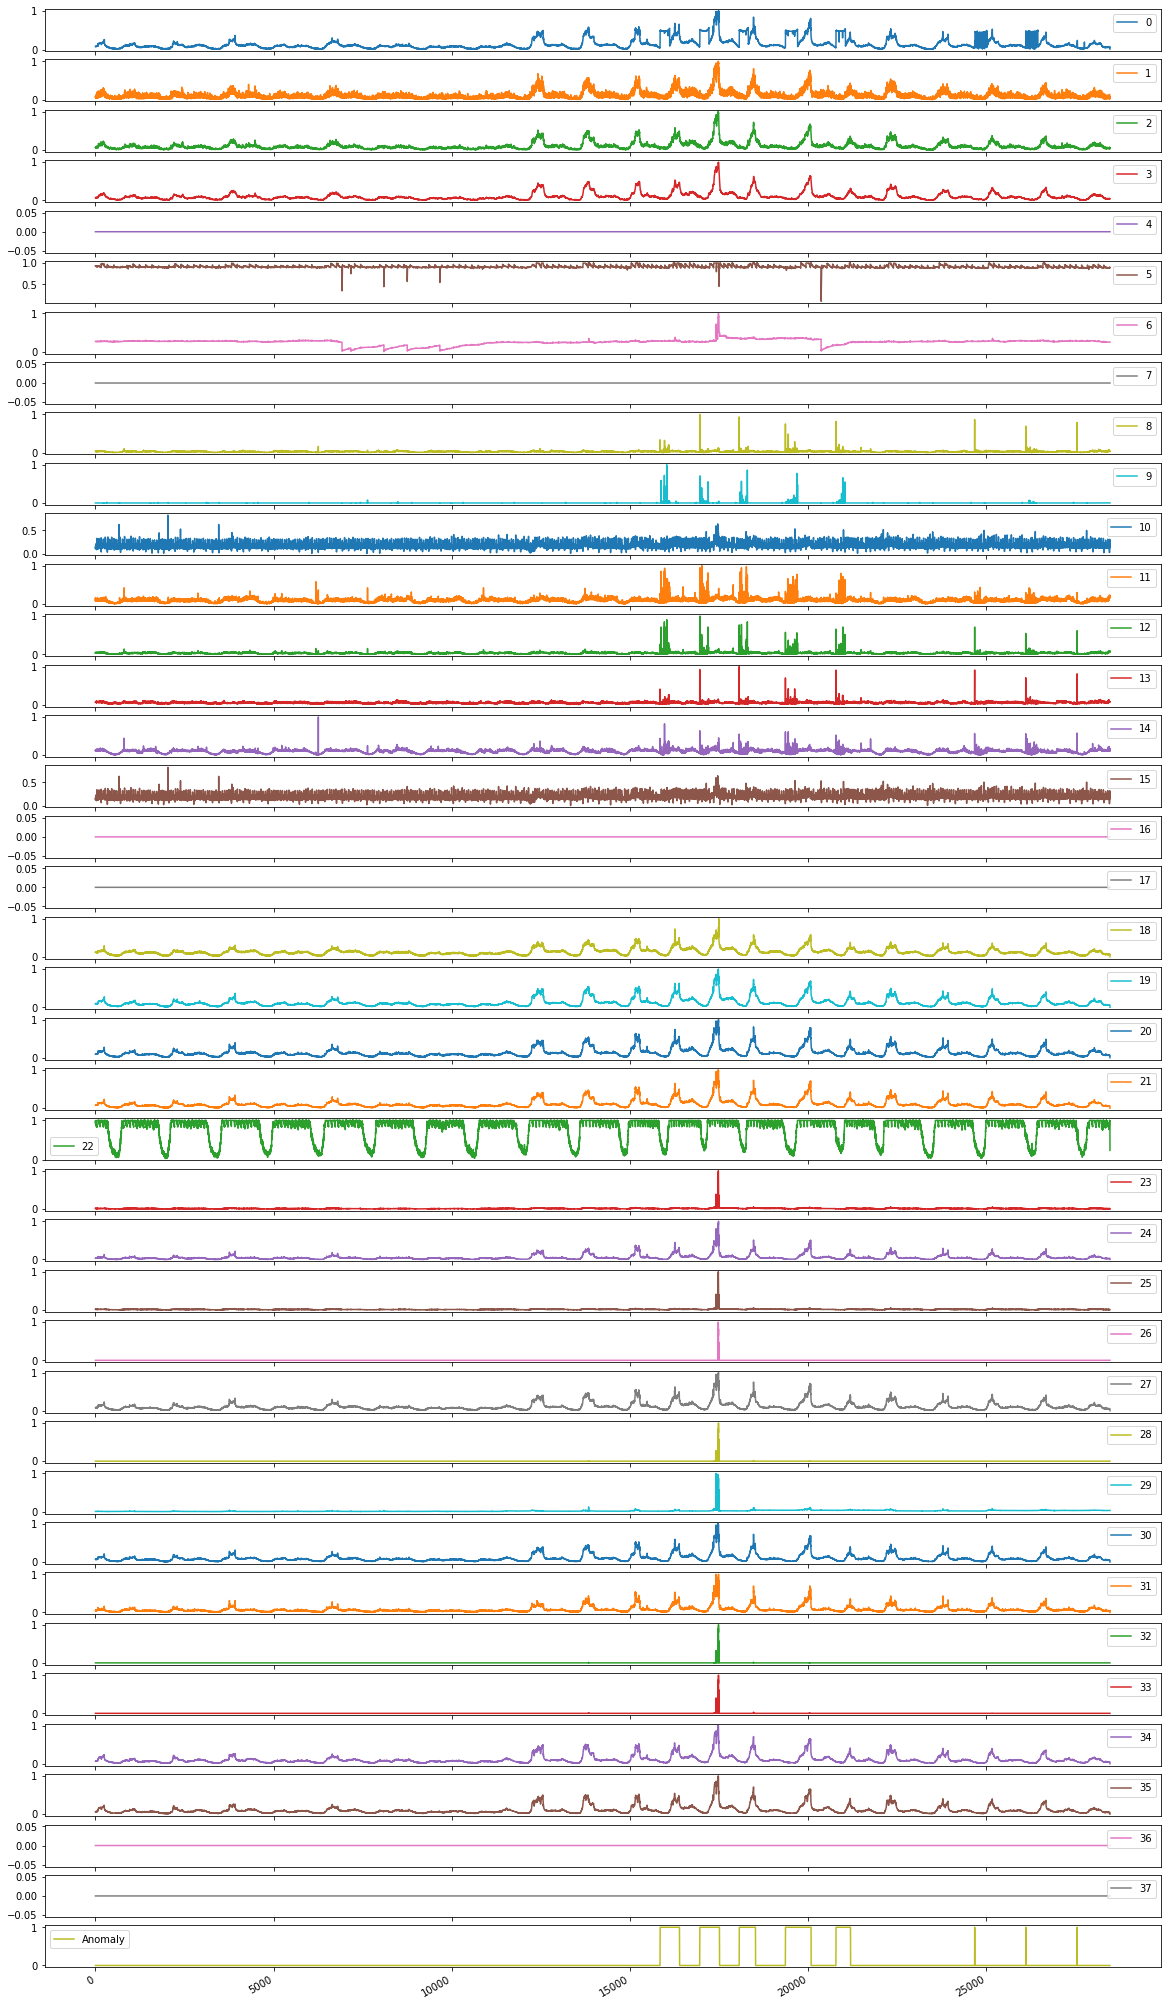

In [7]:
plt.tight_layout()
df_test.plot(subplots=True, figsize=(20,40))
plt.show();

In [144]:
df.shape[0] + df_test.shape[0]

47388

In [145]:
df_comb = pd.concat([df, df_test], ignore_index=True)
df_comb.shape

(47388, 39)

<Figure size 432x288 with 0 Axes>

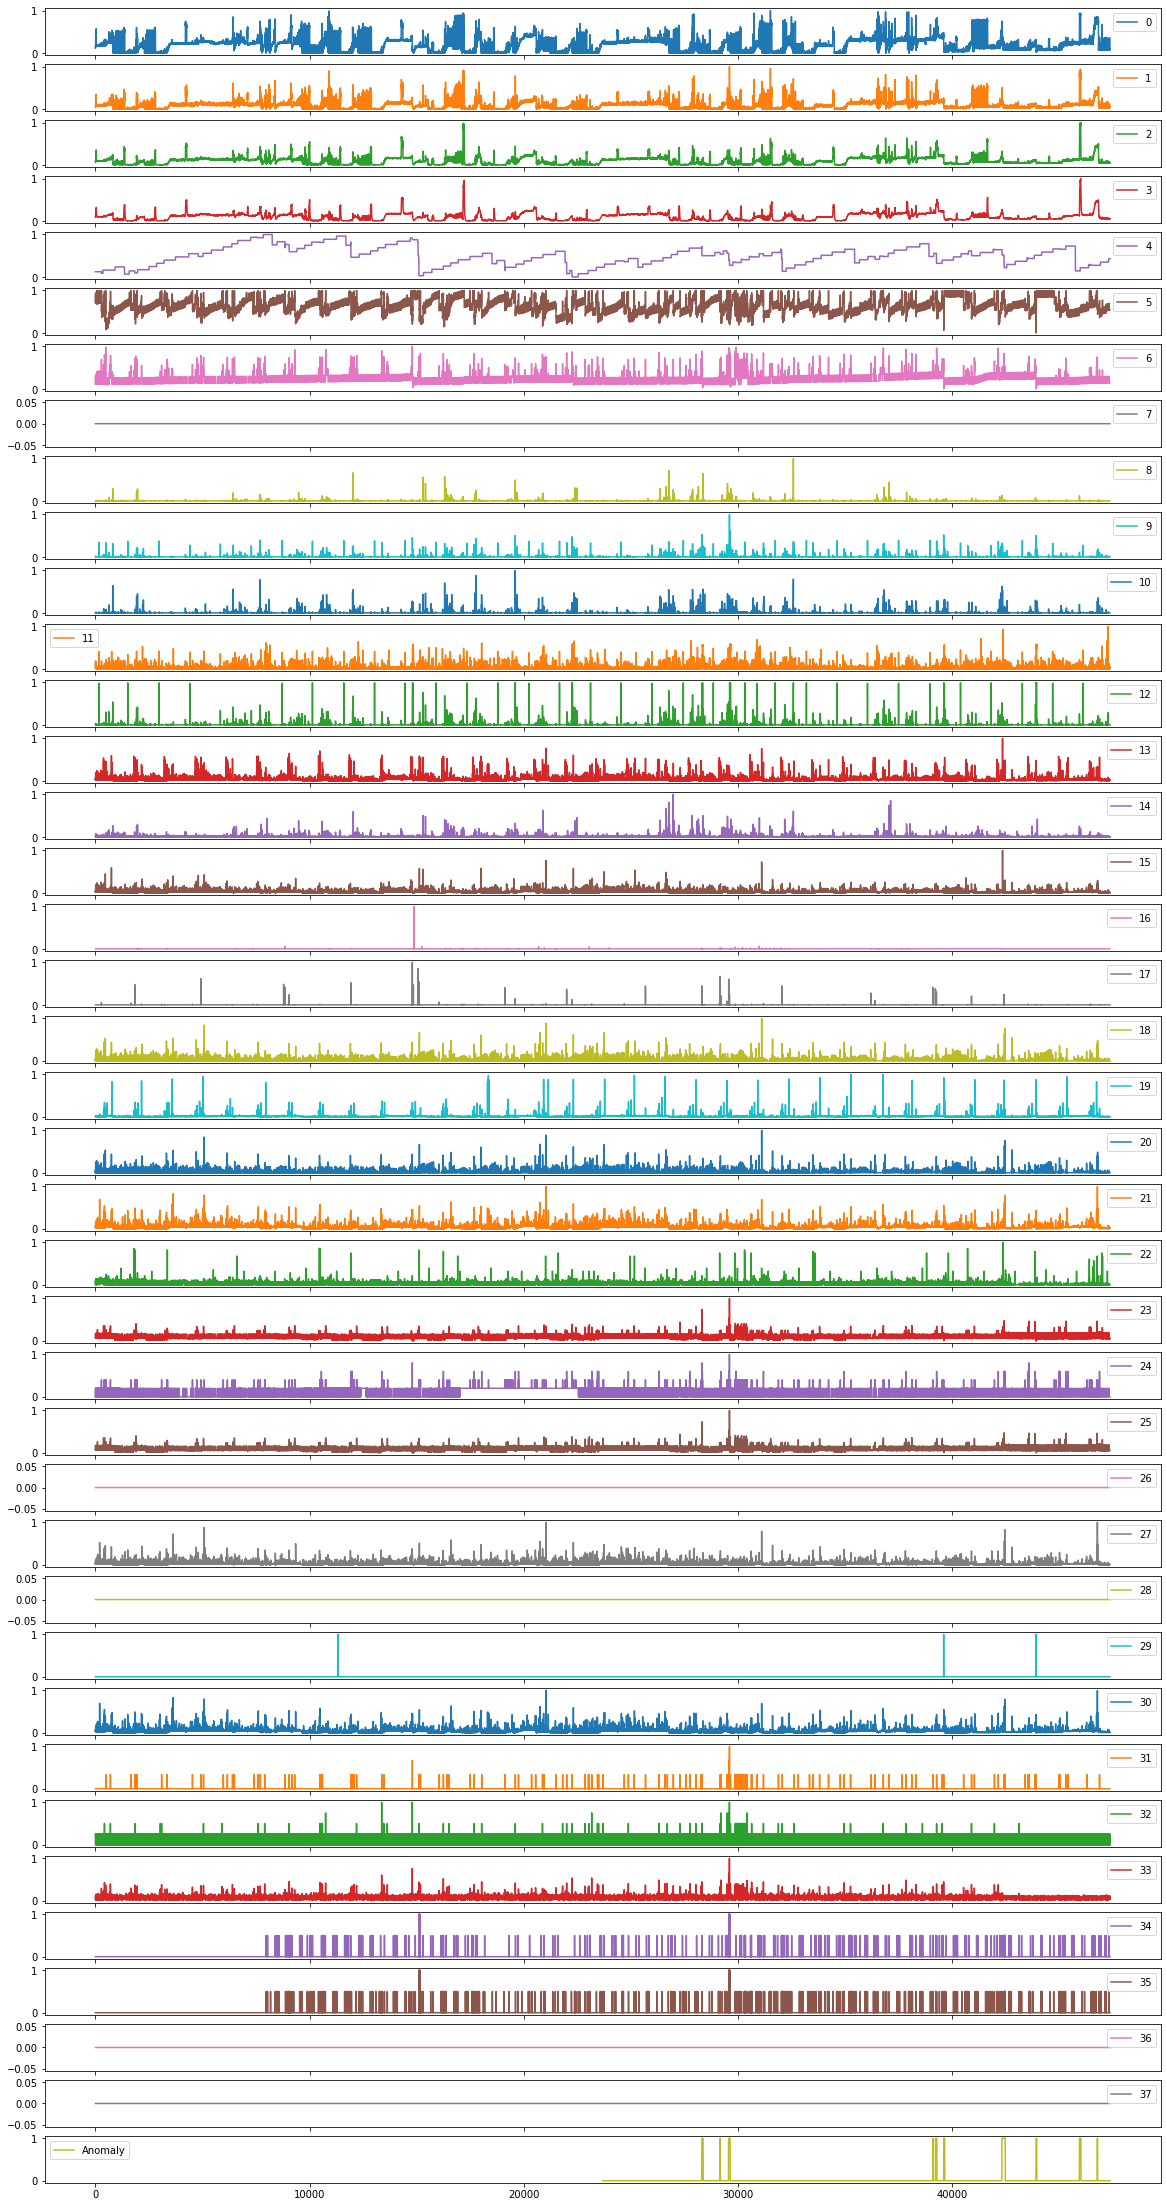

In [146]:
plt.tight_layout()
df_comb.plot(subplots=True, figsize=(20,40))
plt.show();

## Exploring Spectral Residual for removing outliers in training data 

In [147]:
from alibi_detect.od import SpectralResidual
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_ts
from scipy import interpolate

od = SpectralResidual(
    threshold=None,
    window_amp=500,
    window_local=500,
    n_est_points=10,
    n_grad_points=5
)

No threshold level set. Need to infer threshold using `infer_threshold`.


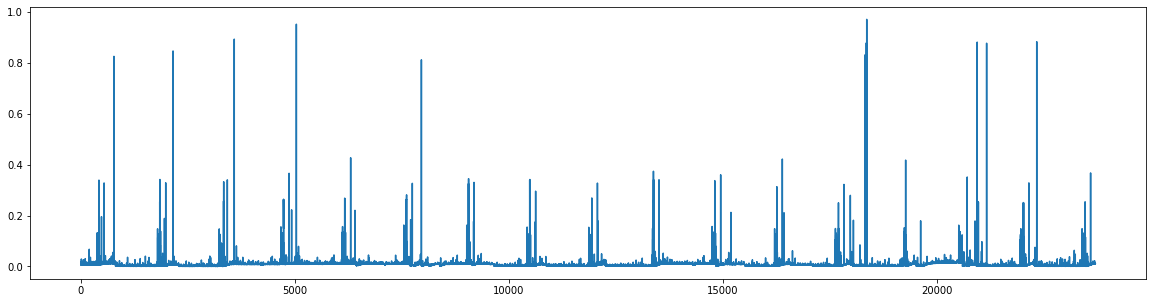

In [175]:
x = df.iloc[:,19].values
plt.figure(figsize=(20, 5))
plt.plot(x)

In [176]:
od.infer_threshold(x, threshold_perc=96)
od.threshold

1.3216224571799693

In [177]:
preds = od.predict(
    x,
    #t=t,  # array with timesteps, assumes dt=1 between observations if omitted
    return_instance_score=True
)

In [178]:
preds

{'data': {'instance_score': array([1.1308772 , 0.54198565, 0.7807328 , ..., 0.46457693, 0.53466127,
         0.40518625]),
  'feature_score': None,
  'is_outlier': array([0, 0, 0, ..., 0, 0, 0])},
 'meta': {'name': 'SpectralResidual',
  'detector_type': 'online',
  'data_type': 'time-series'}}

In [179]:
a_scores = preds['data']['instance_score']
is_a = preds['data']['is_outlier']

print(is_a.shape)
print(x.shape)

(23694,)
(23694,)


In [180]:
x_interp = x.copy()
x_interp[np.where(is_a == 1)] = np.NaN
x_interp = pd.Series(x_interp)
print(pd.isna(x_interp).sum())
x_interp = x_interp.interpolate(method='pad')
print(pd.isna(x_interp).sum())

948
0


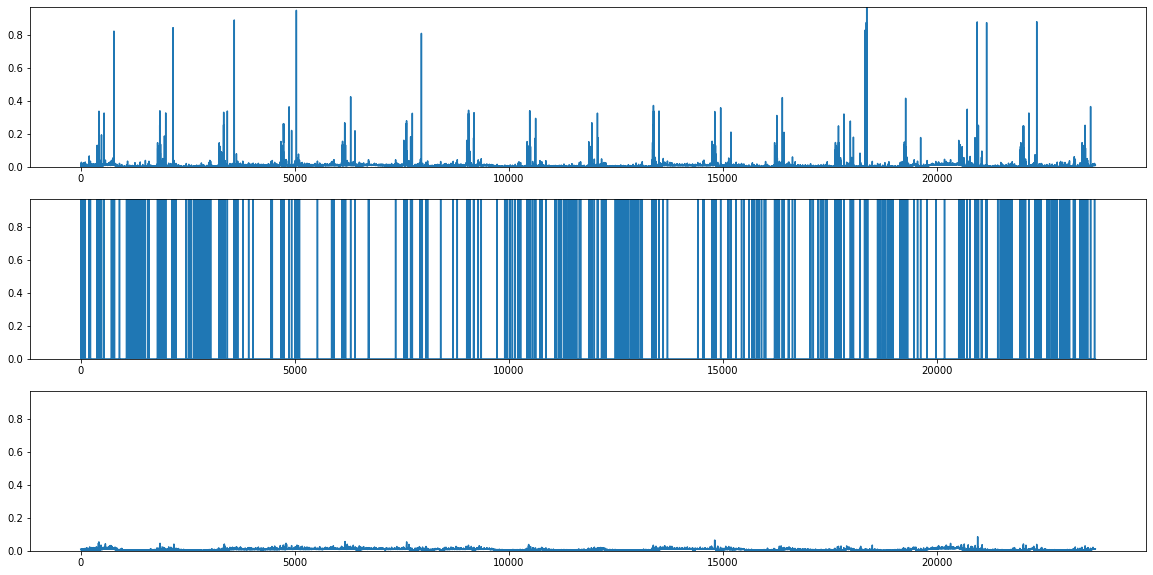

In [181]:

fig, axs = plt.subplots(3, figsize=(20,10))
axs[0].set_ylim([0, max(x)])
axs[1].set_ylim([0, max(x)])
axs[2].set_ylim([0, max(x)])

axs[0].plot(x)
axs[1].plot(is_a)
axs[2].plot(x_interp)


## Results (forecastings, reconstructions, anomaly scores) for trained model on train and test data

In [234]:
output_path = '../output/smd/1-2'

In [235]:
pot = pd.read_pickle(f'{output_path}/anomaly_preds.pkl')
pot.head()

,a_score,pot_threshold,pred_anomaly,anomaly
0,0.020750,0.123415,0,0.0
1,0.021617,0.123415,0,0.0
2,0.024971,0.123415,0,0.0
3,0.017659,0.123415,0,0.0
4,0.023936,0.123415,0,0.0


In [236]:
#output = pd.read_pickle(f'{output_path}/preds.pkl')
#output['Pred_Anomaly'] = pot['pred_anomaly']
#output['True_Anomaly'] = pot['anomaly']

#plt.tight_layout()
#colors = ['gray', 'gray', 'gray', 'r']*(output.shape[1] // 4)
#output.plot(subplots=True, figsize=(20,120), style=colors)
#plt.show();

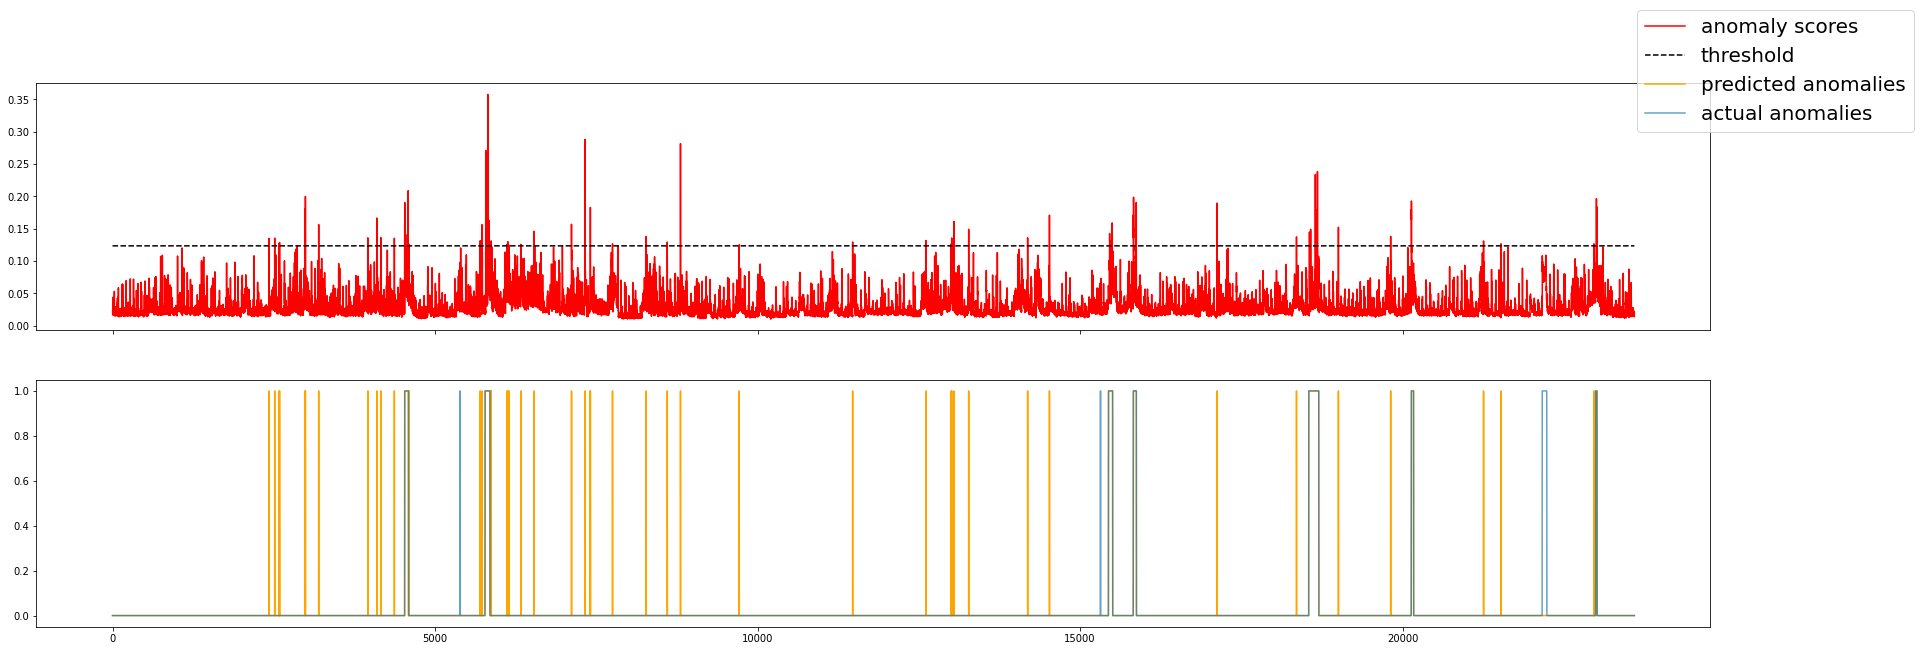

In [237]:
fig, axs = plt.subplots(2, figsize=(30, 10), sharex=True)
axs[0].plot(pot['a_score'], c='r', label='anomaly scores')
axs[0].plot(pot['pot_threshold'], linestyle='dashed', c='black', label='threshold')
axs[1].plot(pot['pred_anomaly'], label='predicted anomalies', c='orange')
axs[1].plot(pot['anomaly'], label='actual anomalies', alpha=0.7, )


fig.legend(prop={'size': 20})
plt.show()

In [238]:
print('precision: ', precision_score(pot['anomaly'], pot['pred_anomaly']))
print('recall:    ', recall_score(pot['anomaly'], pot['pred_anomaly']))
print('f1 score:  ', f1_score(pot['anomaly'], pot['pred_anomaly']))

precision:  0.9005847953216374
recall:     0.8523985239852399
f1 score:   0.8758293838862559


In [11]:
output.head()

,Pred_0,Recon_0,True_0,A_Score_0,Pred_1,Recon_1,True_1,A_Score_1,Pred_2,Recon_2,...,Pred_36,Recon_36,True_36,A_Score_36,Pred_37,Recon_37,True_37,A_Score_37,Pred_Anomaly,True_Anomaly
0,0.023385,0.044677,0.010753,0.046556,0.029192,0.035102,0.008475,0.047344,0.024167,0.030008,...,0.000039,0.001637,0.0,0.001676,-1.105508e-07,0.000859,0.0,0.000859,-1,0
1,0.022224,0.036172,0.021505,0.015386,0.028317,0.030593,0.080508,0.102106,0.023151,0.028540,...,0.000042,-0.001129,0.0,0.001171,-1.300883e-07,0.000669,0.0,0.000669,-1,0
2,0.023167,0.019839,0.021505,0.003328,0.028975,0.031410,0.074153,0.087921,0.023914,0.029693,...,0.000039,-0.000174,0.0,0.000213,-1.132304e-07,0.001722,0.0,0.001722,-1,0
3,0.023371,0.029496,0.021505,0.009857,0.029214,0.029646,0.048729,0.038598,0.024196,0.029024,...,0.000039,-0.001196,0.0,0.001234,-1.097034e-07,0.001564,0.0,0.001564,-1,0
4,0.025514,0.029503,0.021505,0.012007,0.030426,0.029319,0.044492,0.029239,0.025580,0.028628,...,0.000030,-0.000625,0.0,0.000656,-1.086899e-07,0.000844,0.0,0.000844,-1,0


<Figure size 432x288 with 0 Axes>

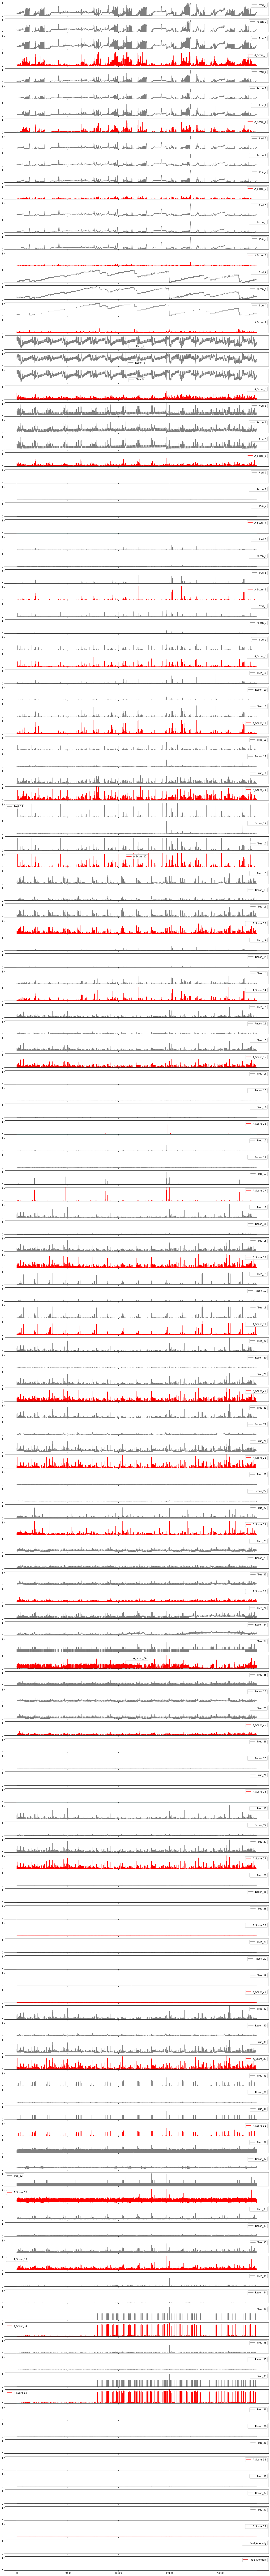

In [187]:
plt.tight_layout()
colors = ['gray', 'gray', 'gray', 'r']*(output.shape[1] // 4)
output.plot(subplots=True, figsize=(20,200), ylim=(0,1.1), style=colors)
plt.show();

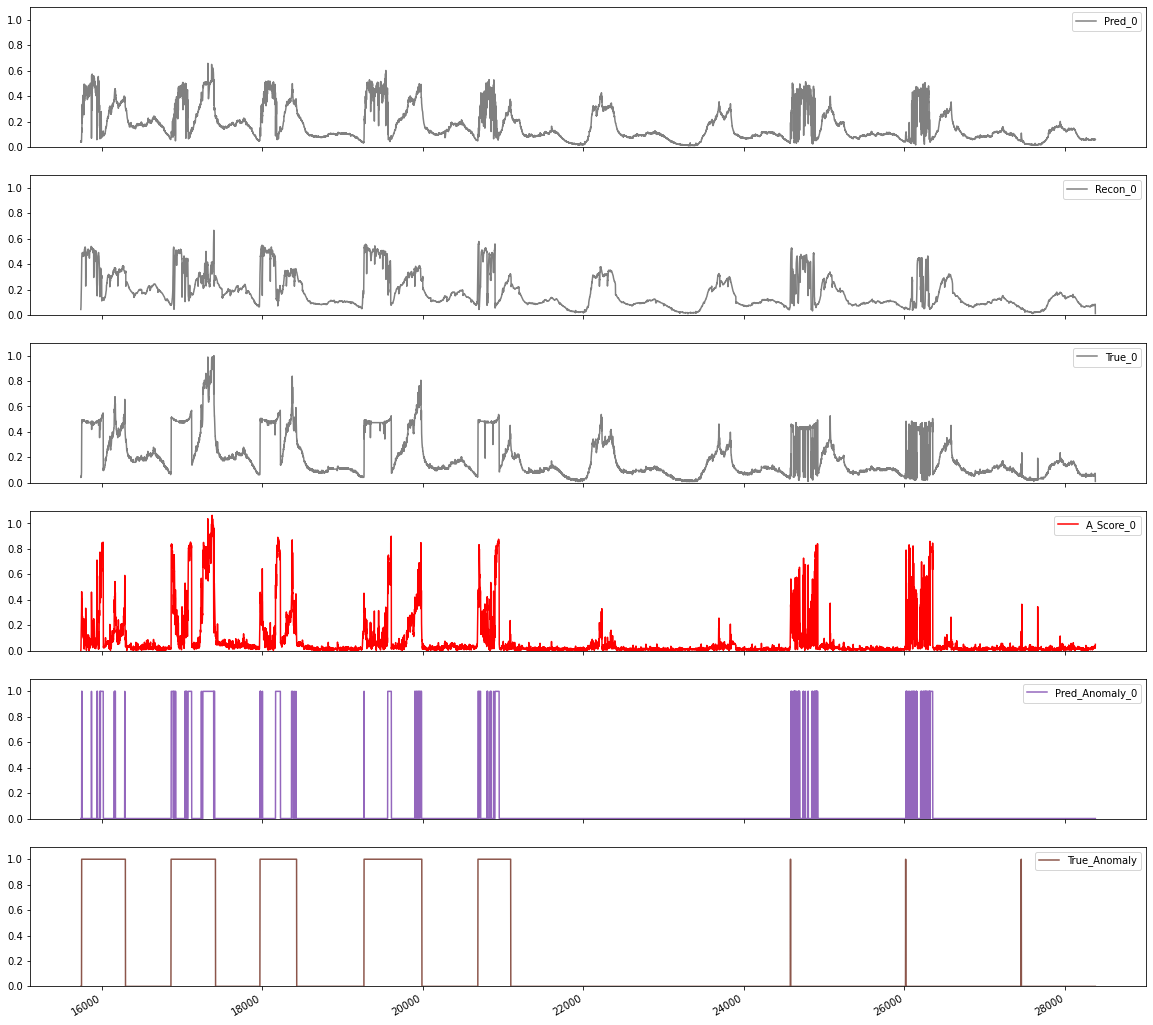

In [293]:
i = 0

# Calculate threshold loss = mean + 3std
rses = output.loc[:, f'A_Score_{i}']
thresh = np.mean(rses) + 3*np.std(rses)

output[f'Pred_Anomaly_{i}'] = (rses > thresh).astype(int)

start, end = 15849, 16368
df = output.loc[start-110:, [f'Pred_{i}', f'Recon_{i}', f'True_{i}', f'A_Score_{i}', f'Pred_Anomaly_{i}','True_Anomaly']]
df.plot(subplots=True, figsize=(20, 20), ylim=(0,1.1), style=['gray', 'gray', 'gray', 'r'])
plt.show()

In [294]:
print(precision_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))
print(recall_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))
print(f1_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))

0.7886944818304172
0.21752041573867856
0.3409950538260111


<Figure size 1440x720 with 0 Axes>

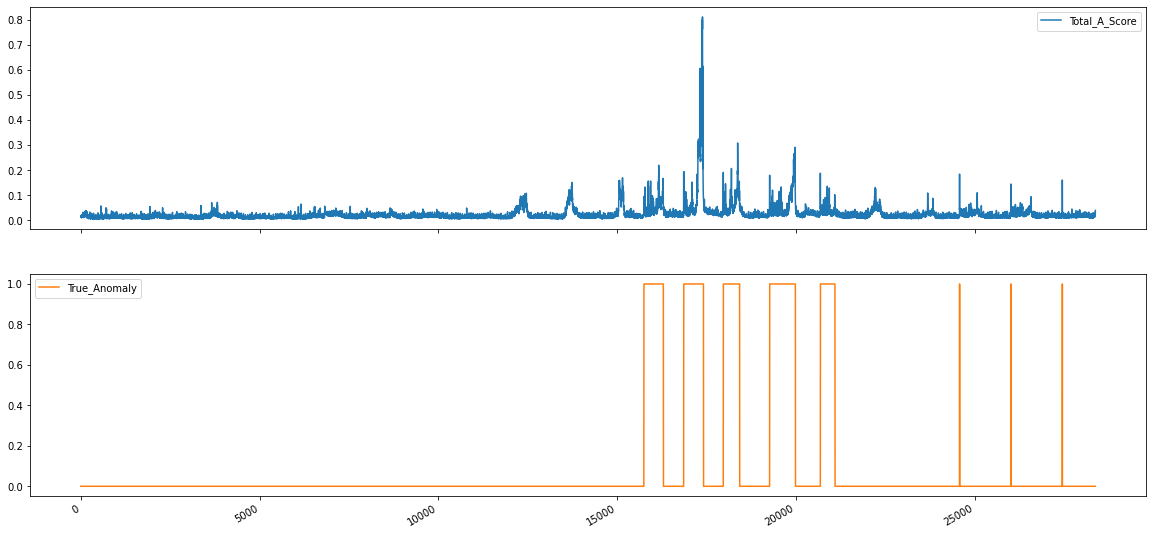

In [295]:
rses = output.loc[:, [f'A_Score_{i}' for i in range(x_dim)]]
output['Total_A_Score'] = rses.mean(1)

plt.figure(figsize=(20, 10))
start, end = 15849, 16368
df = output.loc[:, ['Total_A_Score', 'True_Anomaly']]
df.plot(subplots=True, figsize=(20, 10))
plt.show()


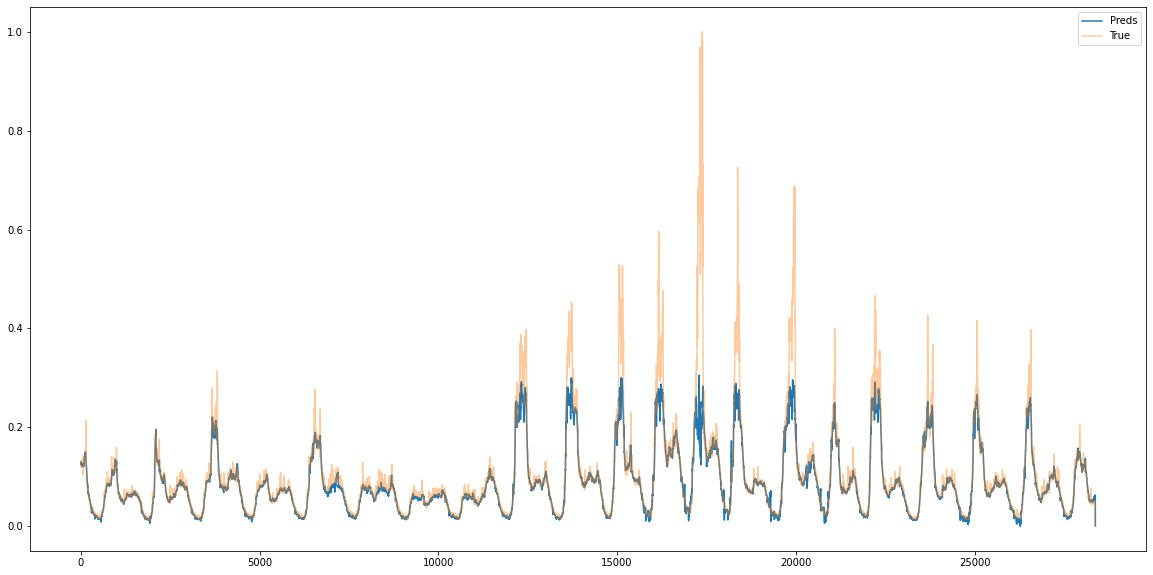

In [296]:
i = 30
# Plot
plt.figure(figsize=(20, 10))
recon = output.loc[:, [f'Recon_{i}']]
true_y = output.loc[:, [f'True_{i}']]

plt.plot(recon.values, label='Preds')
plt.plot(true_y.values, label='True', alpha=0.4)

plt.legend()

In [297]:
# Compute anomaly for every feature
for i in range(38):
    rses = output.loc[:, f'A_Score_{i}']
    thresh = np.mean(rses) + 15*np.std(rses)
    
    output[f'Pred_Anomaly_{i}'] = (rses > thresh).astype(int)

anomaly_preds = output.loc[:, [f'Pred_Anomaly_{i}' for i in range(38)]]
print(anomaly_preds.shape)

output['Pred_Anomaly_Global'] = (np.sum(anomaly_preds, 1) > 1).astype(int)
output.head()

(28379, 38)


,Pred_0,Recon_0,True_0,A_Score_0,Pred_1,Recon_1,True_1,A_Score_1,Pred_2,Recon_2,...,Pred_Anomaly_29,Pred_Anomaly_30,Pred_Anomaly_31,Pred_Anomaly_32,Pred_Anomaly_33,Pred_Anomaly_34,Pred_Anomaly_35,Pred_Anomaly_36,Pred_Anomaly_37,Pred_Anomaly_Global
0,0.141692,0.149757,0.150538,0.009627,0.120846,0.132502,0.153602,0.053855,0.131449,0.128453,...,0,0,0,0,0,0,0,0,0,0
1,0.147164,0.156881,0.161290,0.018535,0.104490,0.137837,0.159958,0.077589,0.128281,0.139390,...,0,0,0,0,0,0,0,0,0,0
2,0.154090,0.156164,0.161290,0.012326,0.113643,0.141576,0.150424,0.045630,0.129484,0.140963,...,0,0,0,0,0,0,0,0,0,0
3,0.149776,0.154873,0.161290,0.017931,0.120297,0.143679,0.115466,0.033044,0.131655,0.144020,...,0,0,0,0,0,0,0,0,0,0
4,0.149155,0.158169,0.161290,0.015257,0.108804,0.140832,0.137712,0.032027,0.120996,0.141898,...,0,0,0,0,0,0,0,0,0,0


In [298]:
print(precision_score(output['True_Anomaly'], output['Pred_Anomaly_Global']))
print(recall_score(output['True_Anomaly'], output['Pred_Anomaly_Global']))
print(f1_score(output['True_Anomaly'], output['Pred_Anomaly_Global']))

0.890625
0.021158129175946547
0.04133430021754895


 ## Evaluation strategy
In [MTAD-GAT paper](https://arxiv.org/pdf/2009.02040.pdf) they follow the evaluation strategy that has become a common evaluation strategy for anomaly detection, for instance [[1] Time-Series Anomaly Detection Service at Microsof](https://arxiv.org/pdf/1906.03821.pdf) and [[2] Unsupervised Anomaly
Detection via Variational Auto-Encoder for Seasonal KPIs in Web Applications](https://arxiv.org/pdf/1802.03903.pdf)

**Strategy**: If any point in an anomaly segment can be detected by the algorithm, and the delay of this point is no more than *k* from the start point of the anomaly segment, we say this segment is detected correctly. Thus, all points in this segment are treated as correct, and the points outside the anomaly segments are treated as normal.

*k* will vary depending on the granularity of the data, and should follow the requirements of real applications. [1] set k = 7 for minutely time-series, k = 3 for hourly time-series and k = 1 for daily time-series. Some people instead set k so that as long as any point within the anomaly segment is classified as an anomaly, the whole segment will be labeled correctly, and instead also outputs the delay.

In [357]:
# Code from Time-Series Anomaly Detection Service at Microsof: https://arxiv.org/pdf/1906.03821.pdf


# Consider delay threshold and missing segments
def get_range_proba(predict, label, delay=7, advance=0):
    # Added advance in case model predicts anomaly 'in advance' within a small window
    # Advance should be 0 or small
    
    splits = np.where(label[1:] != label[:-1])[0] + 1
    print(splits)
    is_anomaly = label[0] == 1
    new_predict = np.array(predict)
    pos = 0

    for sp in splits:
        if is_anomaly:
            if 1 in predict[(pos-advance):min(pos + delay + 1, sp)]:
                new_predict[pos: sp] = 1
            else:
                new_predict[pos: sp] = 0
        is_anomaly = not is_anomaly
        pos = sp
    sp = len(label)

    if is_anomaly:  # anomaly in the end
        if 1 in predict[(pos-advance): min(pos + delay + 1, sp)]:
            new_predict[pos: sp] = 1
        else:
            new_predict[pos: sp] = 0

    return new_predict

[15749 16295 16863 17417 17971 18428 19267 19988 20686 21095 24579 24582
 26014 26016 27454 27456]


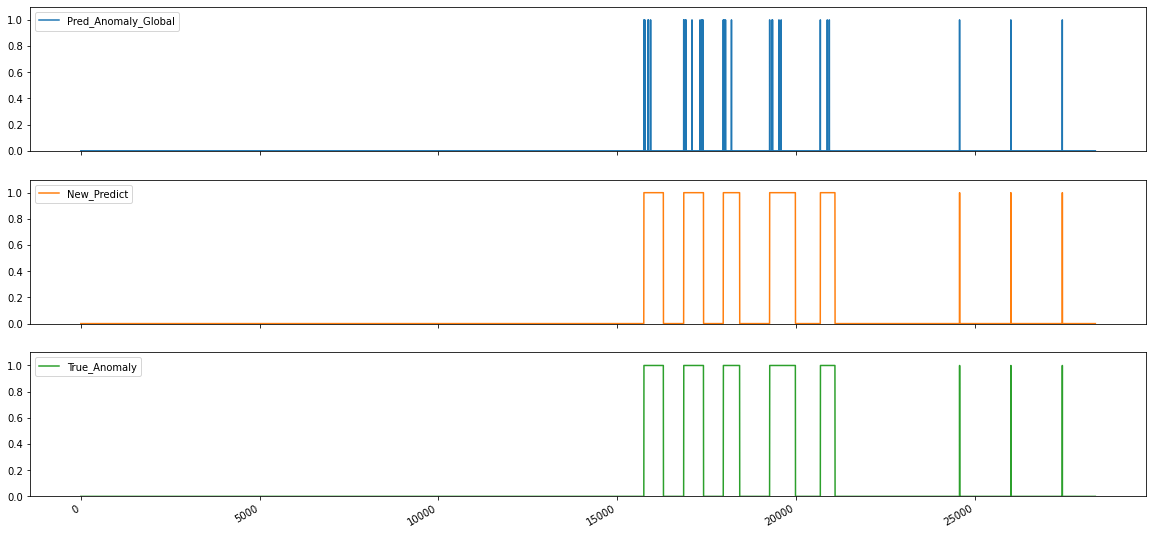

In [358]:
predict = output.loc[:, 'Pred_Anomaly_Global'].values
label = output.loc[:, 'True_Anomaly'].values

output['New_Predict'] = get_range_proba(predict, label, delay=7, advance=1)
output.loc[:, ['Pred_Anomaly_Global', 'New_Predict', 'True_Anomaly']].plot(subplots=True, figsize=(20, 10), ylim=(0,1.1))
plt.show()

In [359]:
print('precision: ', precision_score(output['True_Anomaly'], output['New_Predict']))
print('recall:    ', recall_score(output['True_Anomaly'], output['New_Predict']))
print('f1 score:  ', f1_score(output['True_Anomaly'], output['New_Predict']))

precision:  0.9974083672713809
recall:     1.0
f1 score:   0.9987025023169601


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

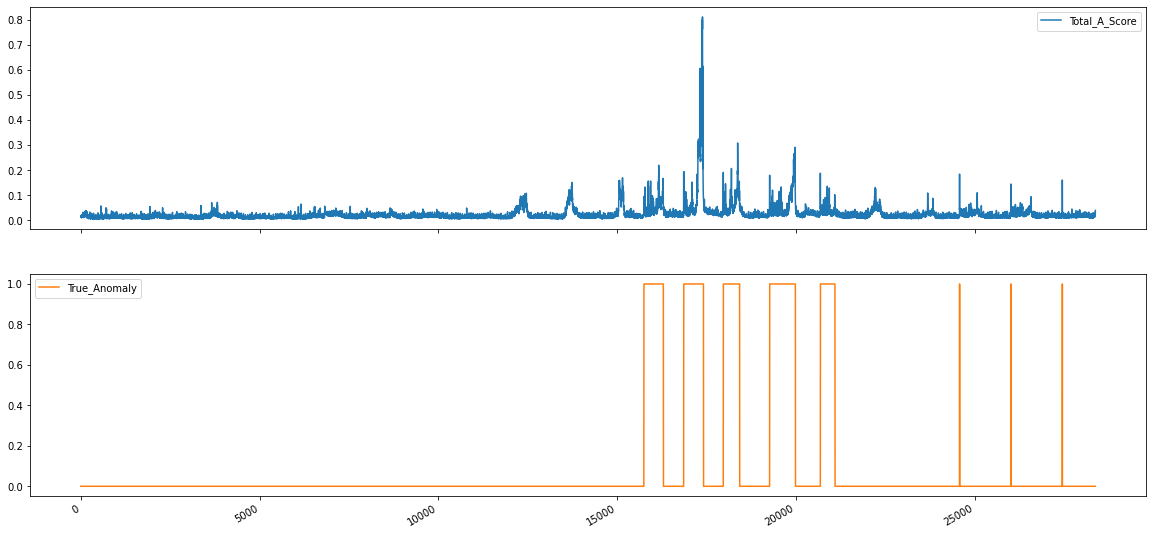

In [255]:
output.loc[:, [f'Total_A_Score', 'True_Anomaly']].plot(subplots=True, figsize=(20, 10))